[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4636/4636 ━━━━━━━━━━━━━━━━━━━━ 153s 32ms/step - loss: 0.0028
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Root Mean Squared Error: 0.3680900198513793


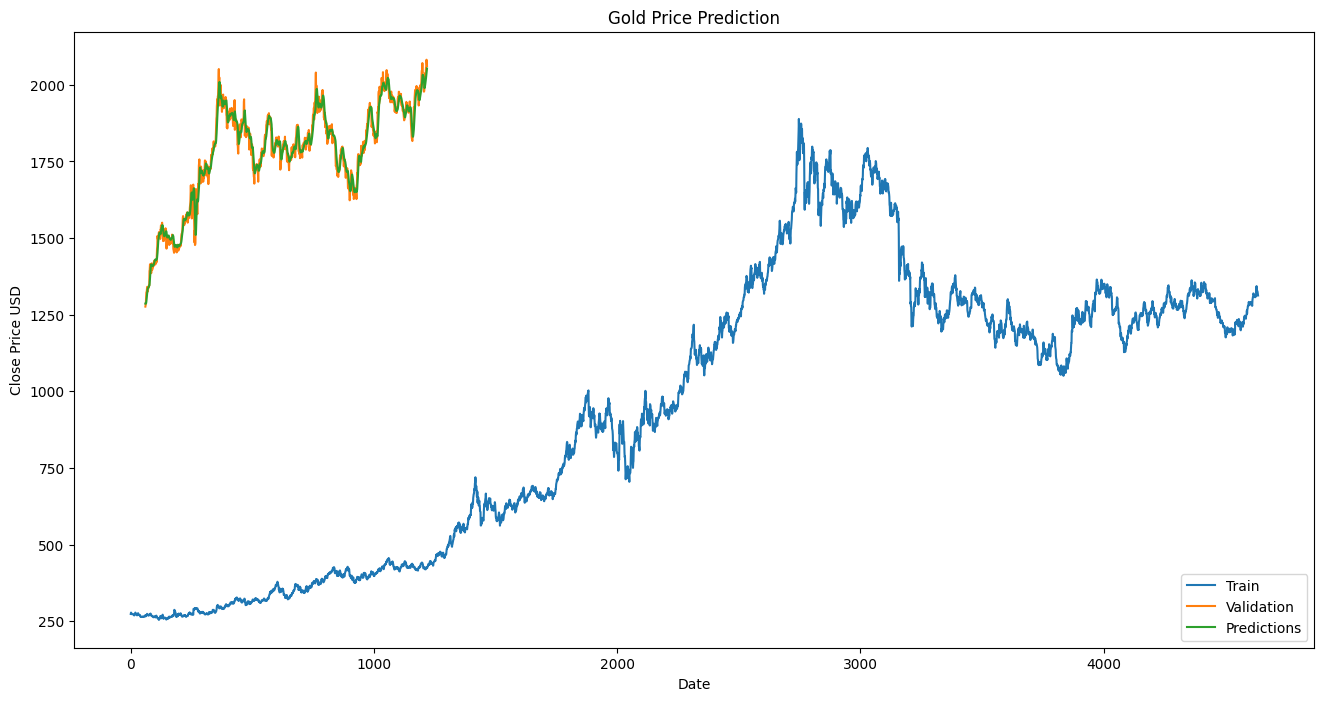

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Step 1: Load the data
gold_data = yf.download('GC=F', start='2000-01-01', end='2024-01-01')

# Use only the 'Close' price for prediction
data = gold_data['Close'].values.reshape(-1, 1)

# Step 2: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 3: Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Set sequence length
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Reshape the input data to be 3D [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Step 4: Split the data into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Step 5: Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Step 7: Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Step 8: Evaluate the model
rmse = np.sqrt(np.mean(predictions - scaler.inverse_transform(y_test.reshape(-1, 1)))**2)
print(f"Root Mean Squared Error: {rmse}")

# Step 9: Plot the results

# Convert the arrays back into a DataFrame
train = pd.DataFrame(data[:split], columns=['Close'])
valid = pd.DataFrame(data[split:], columns=['Close'])

# Trim the 'valid' DataFrame to match the length of predictions
valid = valid.iloc[-len(predictions):]

# Add the predictions to the 'valid' DataFrame
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Gold Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'], label='Train')
plt.plot(valid[['Close', 'Predictions']], label=['Validation', 'Predictions'])
plt.legend(loc='lower right')
plt.show()
